# Length of Stay Prediction - Tree & Ensemble Models


#### Tobias Pfeiffer
#### Deep Learning Final Project

In [76]:
# Basics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.common import random_state
import seaborn as sns 
import functools
import pickle
import ipywidgets as widgets
from IPython.display import display

# Sklearn all
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# other Machine Learning libraries 
!pip install mlens
import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble
from mlens.metrics import rmse
from mlens.ensemble import SuperLearner
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from scipy.stats import percentileofscore
!pip install lime
from lime import lime_tabular
!pip install lightgbm
from lightgbm import LGBMRegressor as lgmr


# Keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Dropout


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load the Data

In [3]:
data_train = pd.read_csv('/content/gdrive/MyDrive/DeepLearning/mimic_train.csv').sort_values('icustay_id')
data_test = pd.read_csv('/content/gdrive/MyDrive/DeepLearning/mimic_test_los.csv').sort_values('icustay_id')

In [4]:
data_train.head(5)

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
2939                      0       55973   152234      200001          83.00   
8618                      0       11861   192256      200010          82.00   
13399                     0       74032   117458      200016          59.00   
10144                     0       61691   109307      200021          65.00   
13836                     1       76603   179633      200024         101.00   

       HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
2939          134.00           99.73      89.00     120.00      104.50  ...   
8618          115.00           95.87     106.00     180.00      130.00  ...   
13399          91.00           67.19      88.00     145.00      116.12  ...   
10144         105.00           86.89      86.00     126.00      108.30  ...   
13836         123.00          112.22      75.00     125.00      102.00  ...   

           Diff  ADMISSION_TYPE  INSURANCE       RELIGION  MARITAL_STATUS  \
2939  -62976.78       EMERGENCY   Medicare         MUSLIM          SINGLE   
8618  -44199.47       EMERGENCY   Medicaid  NOT SPECIFIED          SINGLE   
13399 -51047.92        ELECTIVE   Medicare       CATHOLIC         MARRIED   
10144 -38351.60       EMERGENCY    Private  NOT SPECIFIED         MARRIED   
13836 -42216.13       EMERGENCY   Medicare  NOT SPECIFIED         MARRIED   

                    ETHNICITY                             DIAGNOSIS  \
2939     ASIAN - ASIAN INDIAN                            CELLULITIS   
8618   BLACK/AFRICAN AMERICAN                        UPPER GI BLEED   
13399                   WHITE  POSTERIOR COMMUNICATING ANEURYSM/SDA   
10144                   WHITE                 ALTERED MENTAL STATUS   
13836  BLACK/AFRICAN AMERICAN     URINARY TRACT INFECTION;PNEUMONIA   

       ICD9_diagnosis  FIRST_CAREUNIT  LOS  
2939             6826            MICU 3.08  
8618             5780            MICU 0.97  
13399             430            SICU 0.95  
10144            7804            SICU 1.13  
13836            5070            MICU 0.38  

[5 rows x 44 columns]

In [5]:
data_test.head(5)

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
4930       93535   121562      200011          56.00          82.00   
1052       30375   177945      200044            NaN            NaN   
3412       73241   149216      200049          54.00          76.00   
1725       99052   129142      200063          85.00         102.00   
981        51698   190004      200081          82.00         133.00   

      HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
4930           71.21     123.00     185.00      156.41       37.00  ...   
1052             NaN        NaN        NaN         NaN         NaN  ...   
3412           64.83      95.00     167.00      114.55       33.00  ...   
1725           92.56      91.00     131.00      108.37       42.00  ...   
981            94.32      86.00     143.00      111.09       47.00  ...   

                ADMITTIME      Diff  ADMISSION_TYPE  INSURANCE       RELIGION  \
4930  2188-08-05 20:27:00 -64881.44       EMERGENCY   Medicare         JEWISH   
1052  2135-07-07 16:13:00 -46540.63       EMERGENCY   Medicare       CATHOLIC   
3412  2118-08-14 22:27:00 -38956.86       EMERGENCY    Private         JEWISH   
1725  2141-03-09 23:19:00 -47014.25       EMERGENCY   Medicaid  NOT SPECIFIED   
981   2142-02-23 06:56:00 -47377.26       EMERGENCY   Medicare          OTHER   

      MARITAL_STATUS              ETHNICITY                 DIAGNOSIS  \
4930          SINGLE                  WHITE  ASTHMA;COPD EXACERBATION   
1052         WIDOWED                  WHITE                HEAD BLEED   
3412         MARRIED                  WHITE    HEPATIC ENCEPHALOPATHY   
1725          SINGLE  UNKNOWN/NOT SPECIFIED         TYPE A DISSECTION   
981          MARRIED             PORTUGUESE        PULMONARY EMBOLISM   

      ICD9_diagnosis  FIRST_CAREUNIT  
4930           49322            MICU  
1052           85220            SICU  
3412            5722            MICU  
1725           44101            CSRU  
981            41519             CCU  

[5 rows x 39 columns]

#### Feature Engeniering & Data Exploration

In [6]:
# check which variables are in training data but not in testing data 
col_train = [data_train.columns]
col_test = [data_test.columns]

check_list = list(np.setdiff1d(col_train, col_test))

for i in check_list:
    if i != "LOS":
        del data_train[i]
        
data_train.head(5)

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
2939        55973   152234      200001          83.00         134.00   
8618        11861   192256      200010          82.00         115.00   
13399       74032   117458      200016          59.00          91.00   
10144       61691   109307      200021          65.00         105.00   
13836       76603   179633      200024         101.00         123.00   

       HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
2939            99.73      89.00     120.00      104.50       49.00  ...   
8618            95.87     106.00     180.00      130.00       62.00  ...   
13399           67.19      88.00     145.00      116.12       53.00  ...   
10144           86.89      86.00     126.00      108.30       53.00  ...   
13836          112.22      75.00     125.00      102.00       59.00  ...   

           Diff  ADMISSION_TYPE  INSURANCE       RELIGION  MARITAL_STATUS  \
2939  -62976.78       EMERGENCY   Medicare         MUSLIM          SINGLE   
8618  -44199.47       EMERGENCY   Medicaid  NOT SPECIFIED          SINGLE   
13399 -51047.92        ELECTIVE   Medicare       CATHOLIC         MARRIED   
10144 -38351.60       EMERGENCY    Private  NOT SPECIFIED         MARRIED   
13836 -42216.13       EMERGENCY   Medicare  NOT SPECIFIED         MARRIED   

                    ETHNICITY                             DIAGNOSIS  \
2939     ASIAN - ASIAN INDIAN                            CELLULITIS   
8618   BLACK/AFRICAN AMERICAN                        UPPER GI BLEED   
13399                   WHITE  POSTERIOR COMMUNICATING ANEURYSM/SDA   
10144                   WHITE                 ALTERED MENTAL STATUS   
13836  BLACK/AFRICAN AMERICAN     URINARY TRACT INFECTION;PNEUMONIA   

       ICD9_diagnosis  FIRST_CAREUNIT  LOS  
2939             6826            MICU 3.08  
8618             5780            MICU 0.97  
13399             430            SICU 0.95  
10144            7804            SICU 1.13  
13836            5070            MICU 0.38  

[5 rows x 40 columns]

In [7]:
# inspect all columns
data_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [8]:
# inspect the target variable
data_train['LOS'].describe()

count   20885.00
mean        3.70
std         5.18
min         0.06
25%         1.17
50%         2.02
75%         3.92
max       101.74
Name: LOS, dtype: float64

In [9]:
# this function target encodes string/catgorical variables
def death_rate_calc(column,target):
    col_mean = data_train.groupby(column)[target].mean()
    data_train[column]=data_train[column].replace(to_replace=col_mean.index,value=col_mean.values)
    data_test[column]=data_test[column].replace(to_replace=col_mean.index,value=col_mean.values).fillna(np.nan)

In [10]:
cat_col=['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'MARITAL_STATUS']

for col in cat_col:
    death_rate_calc(col,'LOS')

In [11]:
# convert the time variables and more feature engineering
for df in [data_train, data_test]:
    df['ADMITTIME_y'] = pd.to_datetime(df['ADMITTIME'], errors = 'coerce').dt.year
    df['DOB_y'] = pd.to_datetime(df['DOB'], errors = 'coerce').dt.year
    df['AGE'] = df['ADMITTIME_y'] - df['DOB_y']
    # get the percentile of the age distribution, to make sure I can adeuquatly 
    # compare the age percentiles I set the train data as a benchmark
    df['AGE_PERC'] = percentileofscore(data_train['AGE'], df['AGE'])
    # delete columns that are not needed anymore 
    del df['ICD9_diagnosis'], df['DOB'], df['DOB_y'], df['ADMITTIME'], df['ADMITTIME_y'], df['Diff']
    # del df['DIAGNOSIS']
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 2939 to 19287
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      20885 non-null  int64  
 1   hadm_id         20885 non-null  int64  
 2   icustay_id      20885 non-null  int64  
 3   HeartRate_Min   18698 non-null  float64
 4   HeartRate_Max   18698 non-null  float64
 5   HeartRate_Mean  18698 non-null  float64
 6   SysBP_Min       18677 non-null  float64
 7   SysBP_Max       18677 non-null  float64
 8   SysBP_Mean      18677 non-null  float64
 9   DiasBP_Min      18676 non-null  float64
 10  DiasBP_Max      18676 non-null  float64
 11  DiasBP_Mean     18676 non-null  float64
 12  MeanBP_Min      18699 non-null  float64
 13  MeanBP_Max      18699 non-null  float64
 14  MeanBP_Mean     18699 non-null  float64
 15  RespRate_Min    18696 non-null  float64
 16  RespRate_Max    18696 non-null  float64
 17  RespRate_Mean   18696 non-nu

In [12]:
# to account for Diagnosis that are in the training set but not in the testing set
# i will set them to NaN
data_test['DIAGNOSIS'] = data_test['DIAGNOSIS'].apply(lambda x: np.nan if (type(x) == str) else x)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 4930 to 4504
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      5221 non-null   int64  
 1   hadm_id         5221 non-null   int64  
 2   icustay_id      5221 non-null   int64  
 3   HeartRate_Min   4676 non-null   float64
 4   HeartRate_Max   4676 non-null   float64
 5   HeartRate_Mean  4676 non-null   float64
 6   SysBP_Min       4670 non-null   float64
 7   SysBP_Max       4670 non-null   float64
 8   SysBP_Mean      4670 non-null   float64
 9   DiasBP_Min      4669 non-null   float64
 10  DiasBP_Max      4669 non-null   float64
 11  DiasBP_Mean     4669 non-null   float64
 12  MeanBP_Min      4674 non-null   float64
 13  MeanBP_Max      4674 non-null   float64
 14  MeanBP_Mean     4674 non-null   float64
 15  RespRate_Min    4675 non-null   float64
 16  RespRate_Max    4675 non-null   float64
 17  RespRate_Mean   4675 non-null 

Plot the Data Set

Since the pair plot is computationally expensive I will take a sample to plot the data

In [13]:
sample=data_train.sample(6000, axis=0, replace=False)

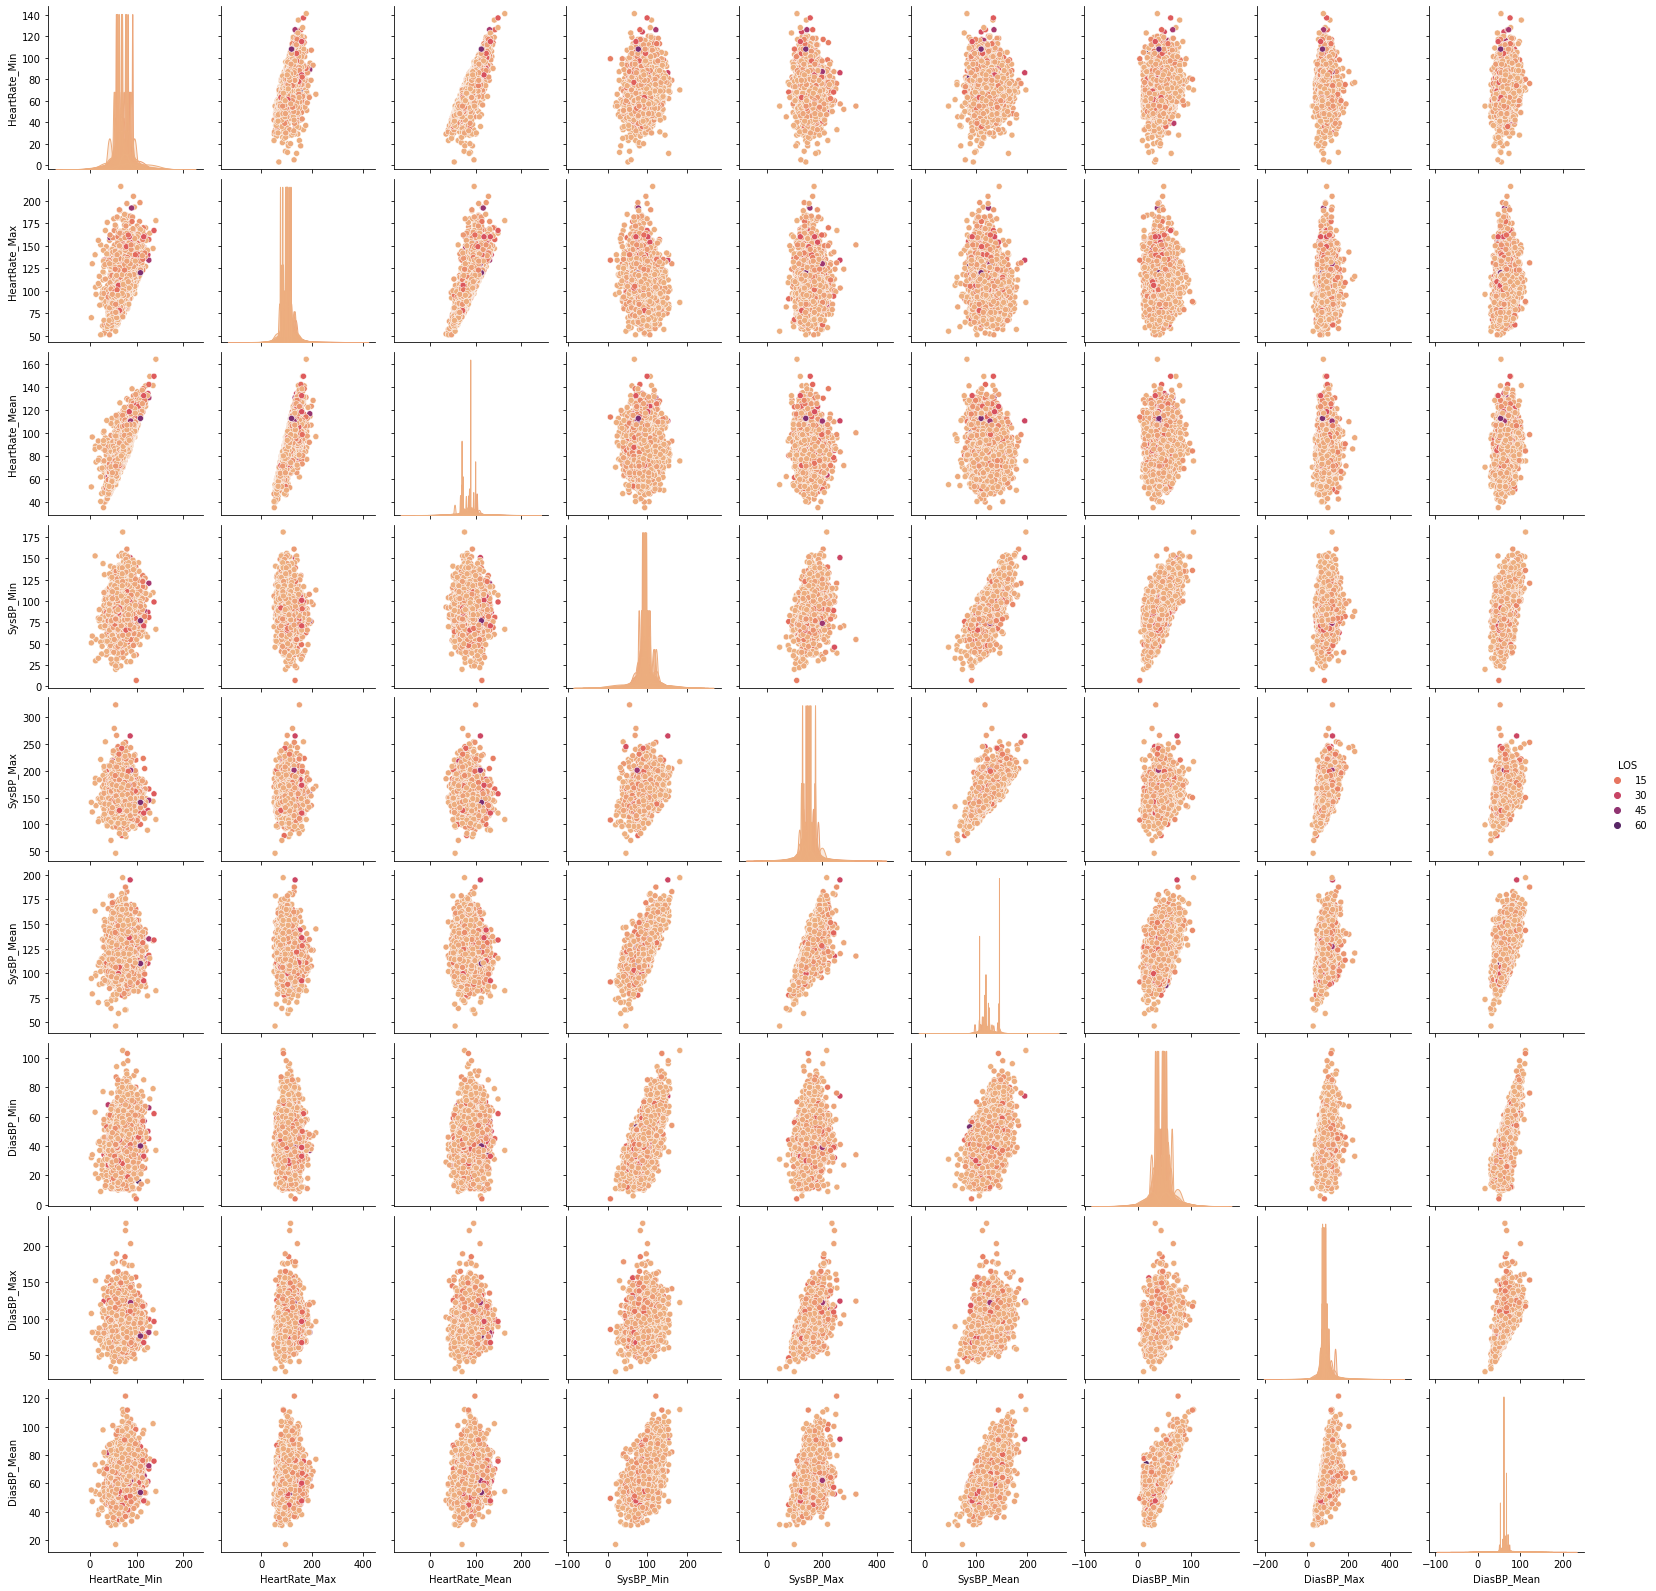

In [14]:
sns.pairplot(sample[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'LOS']], hue='LOS', palette = "flare")

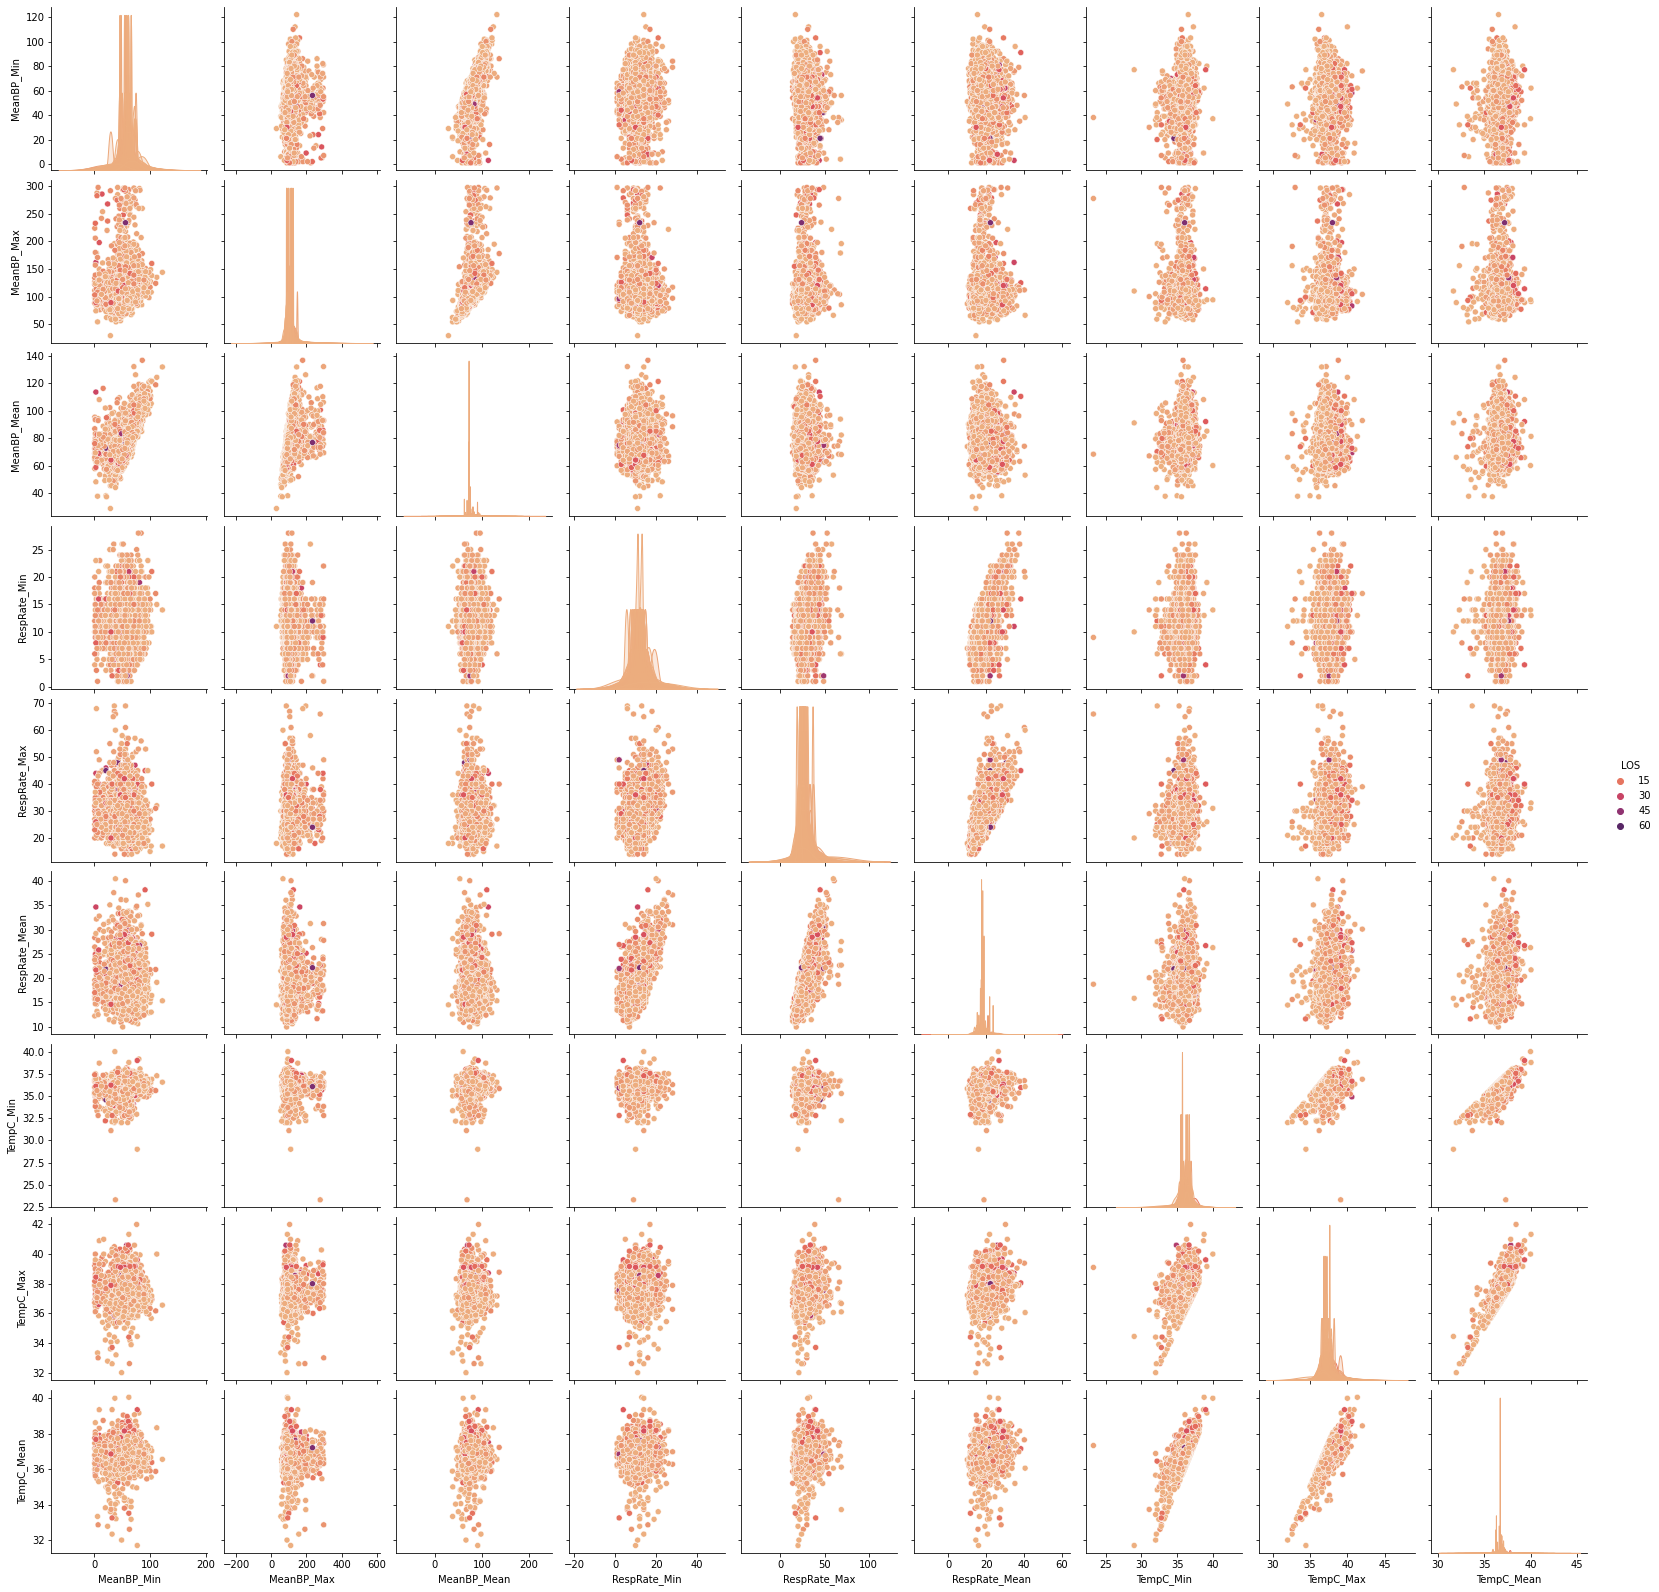

In [15]:
sns.pairplot(sample[['MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'LOS']], hue='LOS', palette="flare")

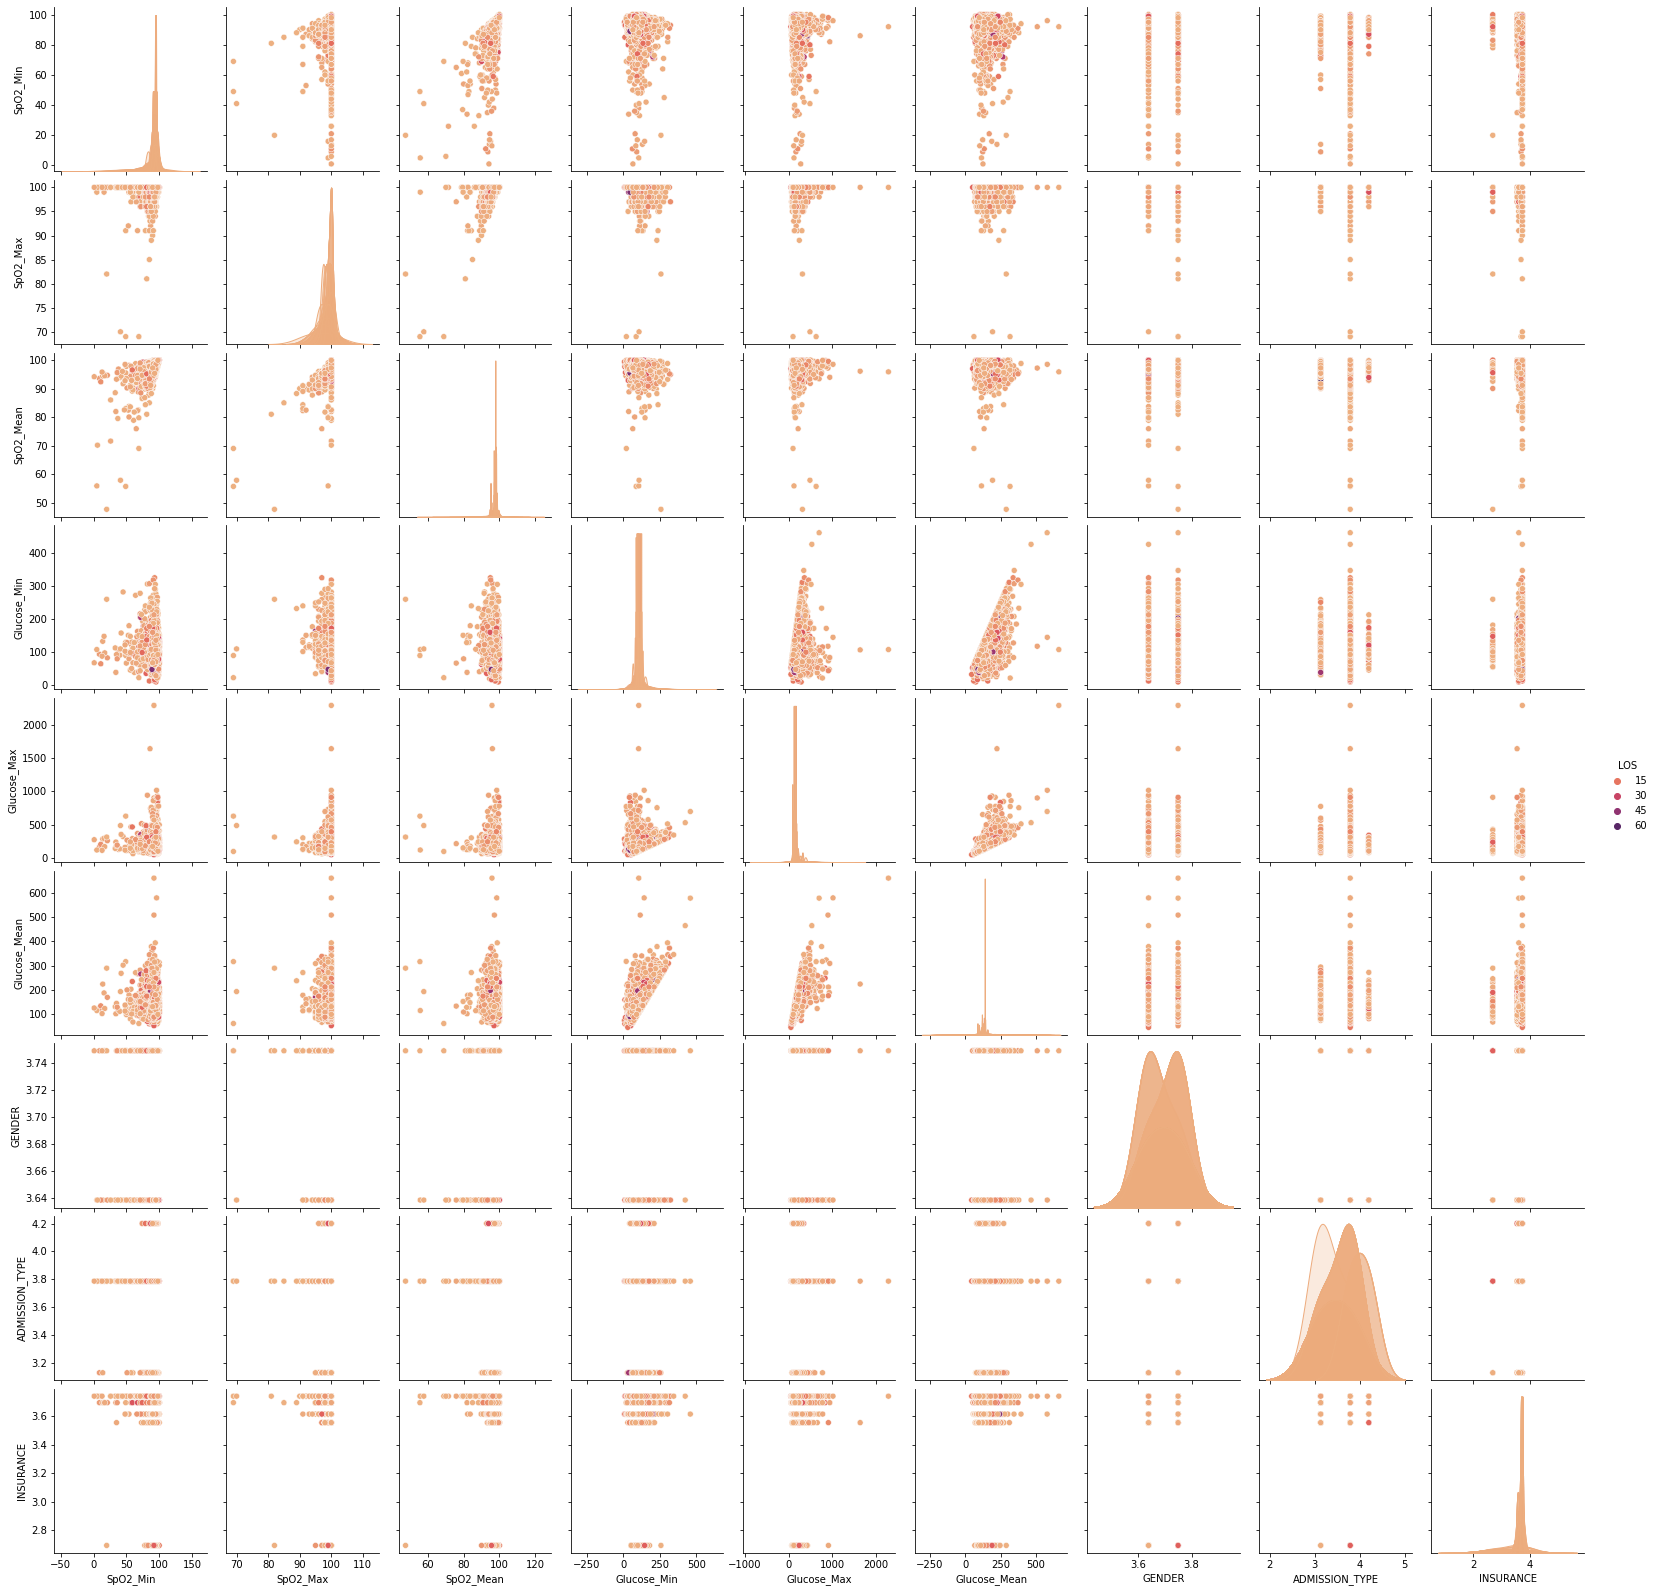

In [16]:
sns.pairplot(sample[['SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'GENDER','ADMISSION_TYPE', 'INSURANCE', 'LOS']], hue='LOS', palette="flare")

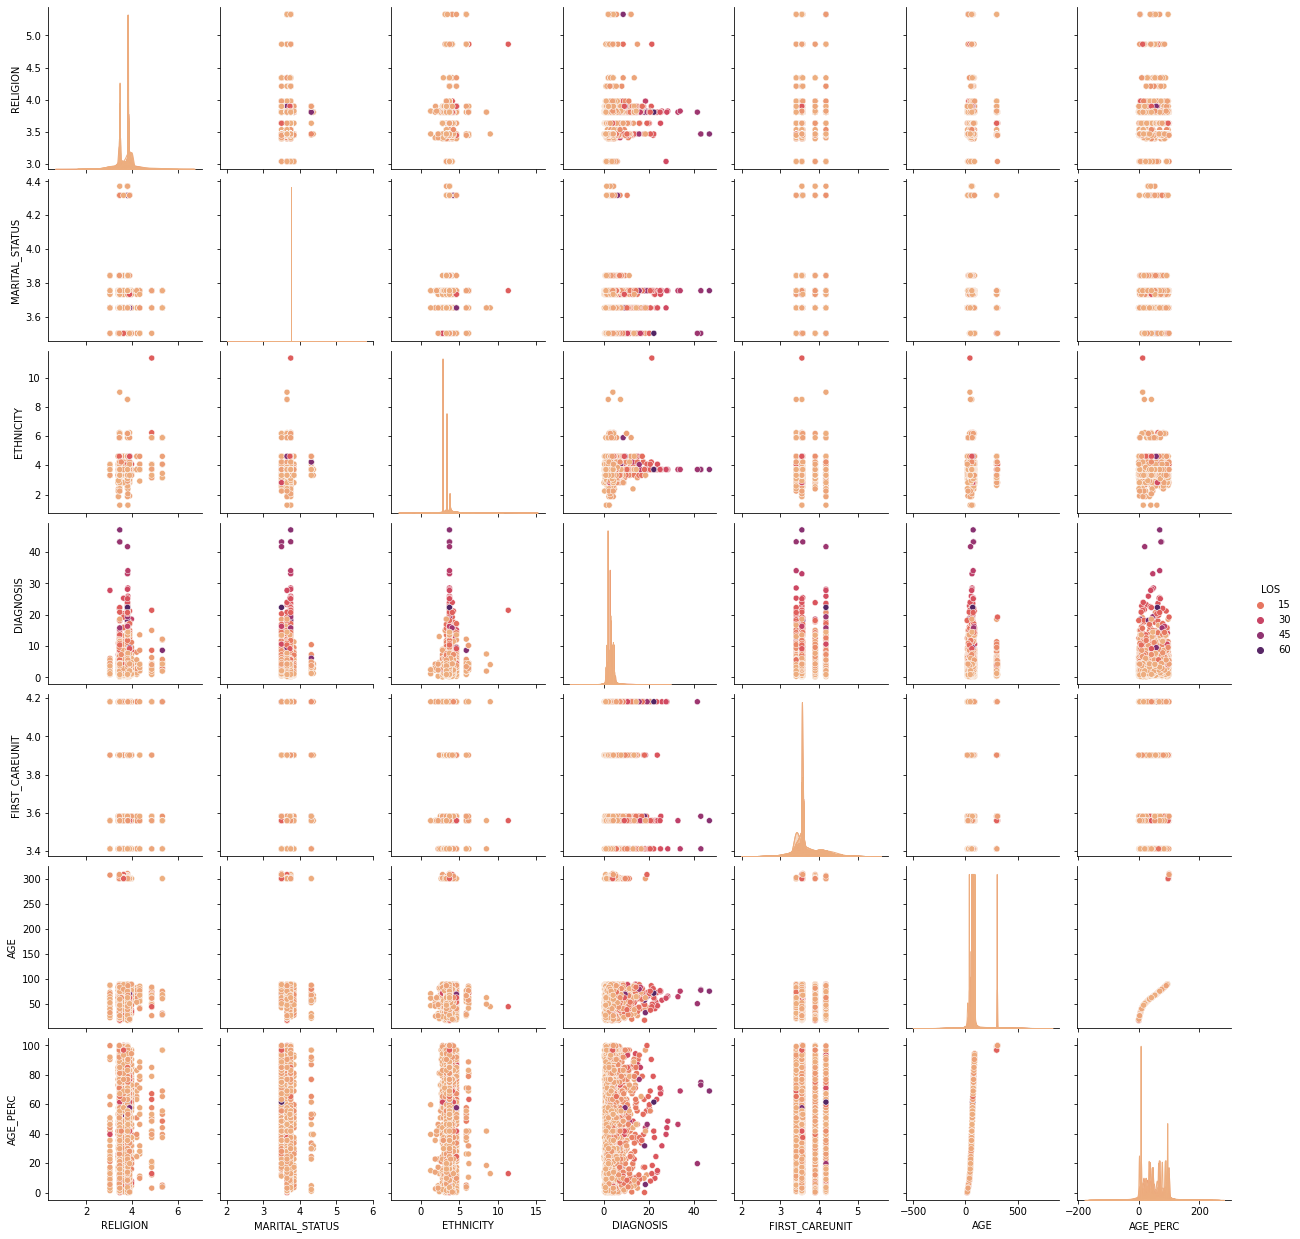

In [17]:
sns.pairplot(sample[['RELIGION','MARITAL_STATUS', 'ETHNICITY', 
                     'DIAGNOSIS','FIRST_CAREUNIT', 'AGE',
                     'AGE_PERC', 'LOS']], hue='LOS', palette="flare")

In [18]:
# A lot of the viatal seem sweked so I will log them
numerical_columns = ['HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS']

for df in [data_train, data_test]:
  for c in df.columns:
    if c in numerical_columns:
      df[c] = np.log(df[c]+1)

In [19]:
df[numerical_columns]

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
4930           4.04           4.42            4.28       4.82       5.23   
1052            NaN            NaN             NaN        NaN        NaN   
3412           4.01           4.34            4.19       4.56       5.12   
1725           4.45           4.63            4.54       4.52       4.88   
981            4.42           4.90            4.56       4.47       4.97   
...             ...            ...             ...        ...        ...   
1511           4.25           4.60            4.40       4.03       4.92   
269            4.06           4.62            4.37       4.82       5.20   
3460           4.43           4.60            4.52       4.69       5.12   
850            4.03           4.65            4.30       4.70       5.11   
4504           3.85           4.41            4.13       4.49       4.98   

      SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
4930        5.06        3.64        4.44         4.11        4.11  ...   
1052         NaN         NaN         NaN          NaN         NaN  ...   
3412        4.75        3.53        4.39         3.79        3.91  ...   
1725        4.69        3.76        4.17         4.00        2.71  ...   
981         4.72        3.87        4.52         4.18        4.06  ...   
...          ...         ...         ...          ...         ...  ...   
1511        4.62        3.78        4.30         4.02        3.85  ...   
269         5.07        4.30        4.63         4.46        4.55  ...   
3460        4.89        3.83        4.63         4.27        4.16  ...   
850         4.97        3.47        4.29         4.12        3.89  ...   
4504        4.79        3.76        4.52         4.10        4.03  ...   

      TempC_Min  TempC_Max  TempC_Mean  SpO2_Min  SpO2_Max  SpO2_Mean  \
4930       3.62       3.65        3.64      4.50      4.62       4.57   
1052        NaN        NaN         NaN       NaN       NaN        NaN   
3412       3.62       3.65        3.63      4.49      4.62       4.57   
1725        NaN        NaN         NaN      4.48      4.62       4.58   
981        3.60       3.69        3.65      4.53      4.62       4.57   
...         ...        ...         ...       ...       ...        ...   
1511       3.61       3.65        3.63      4.52      4.62       4.58   
269        3.63       3.65        3.64      4.51      4.61       4.57   
3460       3.58       3.61        3.60      4.54      4.60       4.57   
850        3.64       3.66        3.65      4.60      4.62       4.61   
4504       3.61       3.64        3.63      4.56      4.62       4.59   

      Glucose_Min  Glucose_Max  Glucose_Mean  DIAGNOSIS  
4930         4.55         4.69          4.62       1.53  
1052         4.84         4.84          4.84       1.66  
3412         4.84         5.70          5.30       1.61  
1725         4.56         5.28          4.85       2.64  
981          4.41         4.91          4.78       1.11  
...           ...          ...           ...        ...  
1511         4.38         5.08          4.84        NaN  
269          4.58         4.82          4.69       1.76  
3460         4.34         4.98          4.74       1.33  
850          4.64         5.06          4.90       1.67  
4504         4.87         5.14          5.04       1.90  

[5221 rows x 25 columns]

Imputing Missing Data

In [20]:
imputer = KNNImputer(weights = "distance")

train = pd.DataFrame(imputer.fit_transform(data_train))
train.columns = data_train.columns
train.index = data_train.index
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 2939 to 19287
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      20885 non-null  float64
 1   hadm_id         20885 non-null  float64
 2   icustay_id      20885 non-null  float64
 3   HeartRate_Min   20885 non-null  float64
 4   HeartRate_Max   20885 non-null  float64
 5   HeartRate_Mean  20885 non-null  float64
 6   SysBP_Min       20885 non-null  float64
 7   SysBP_Max       20885 non-null  float64
 8   SysBP_Mean      20885 non-null  float64
 9   DiasBP_Min      20885 non-null  float64
 10  DiasBP_Max      20885 non-null  float64
 11  DiasBP_Mean     20885 non-null  float64
 12  MeanBP_Min      20885 non-null  float64
 13  MeanBP_Max      20885 non-null  float64
 14  MeanBP_Mean     20885 non-null  float64
 15  RespRate_Min    20885 non-null  float64
 16  RespRate_Max    20885 non-null  float64
 17  RespRate_Mean   20885 non-nu

In [21]:
test = pd.DataFrame(imputer.fit(data_train.drop(columns=['LOS'], axis = 1)).transform(data_test))
test.columns = data_test.columns
test.index = data_test.index
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 4930 to 4504
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      5221 non-null   float64
 1   hadm_id         5221 non-null   float64
 2   icustay_id      5221 non-null   float64
 3   HeartRate_Min   5221 non-null   float64
 4   HeartRate_Max   5221 non-null   float64
 5   HeartRate_Mean  5221 non-null   float64
 6   SysBP_Min       5221 non-null   float64
 7   SysBP_Max       5221 non-null   float64
 8   SysBP_Mean      5221 non-null   float64
 9   DiasBP_Min      5221 non-null   float64
 10  DiasBP_Max      5221 non-null   float64
 11  DiasBP_Mean     5221 non-null   float64
 12  MeanBP_Min      5221 non-null   float64
 13  MeanBP_Max      5221 non-null   float64
 14  MeanBP_Mean     5221 non-null   float64
 15  RespRate_Min    5221 non-null   float64
 16  RespRate_Max    5221 non-null   float64
 17  RespRate_Mean   5221 non-null 

Now I inspect the target variable

In [22]:
p = train.corr()['LOS']
print(p)

subject_id       -0.00
hadm_id           0.01
icustay_id       -0.01
HeartRate_Min     0.07
HeartRate_Max     0.13
HeartRate_Mean    0.10
SysBP_Min        -0.11
SysBP_Max         0.06
SysBP_Mean       -0.04
DiasBP_Min       -0.06
DiasBP_Max        0.02
DiasBP_Mean      -0.05
MeanBP_Min       -0.10
MeanBP_Max        0.08
MeanBP_Mean      -0.02
RespRate_Min     -0.00
RespRate_Max      0.15
RespRate_Mean     0.13
TempC_Min        -0.02
TempC_Max         0.15
TempC_Mean        0.09
SpO2_Min         -0.03
SpO2_Max          0.06
SpO2_Mean         0.03
Glucose_Min      -0.03
Glucose_Max       0.10
Glucose_Mean      0.06
GENDER            0.01
ADMISSION_TYPE    0.04
INSURANCE         0.02
RELIGION          0.04
MARITAL_STATUS    0.02
ETHNICITY         0.07
DIAGNOSIS         0.49
FIRST_CAREUNIT    0.05
LOS               1.00
AGE              -0.02
AGE_PERC          0.01
Name: LOS, dtype: float64


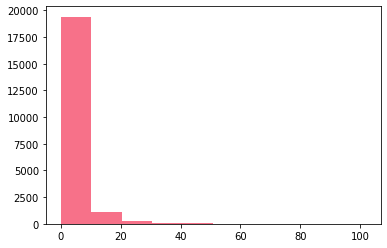

In [23]:
plt.hist(data_train['LOS'])
plt.show() 

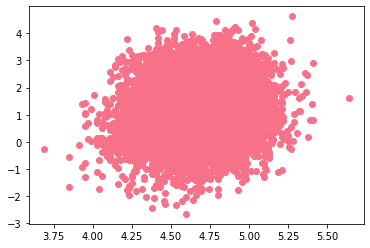

In [24]:
plt.scatter(data_train['HeartRate_Max'], np.log(data_train['LOS']))

#### Helper Functions
In this section I define some functions and metrics that I will reuse throughout the script.

In [25]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [42]:
# this function finds and fits the best model through GridSearchCV 

def tuning(model, parameters, X_train, y_train):
    
    random_estimator = RandomizedSearchCV(estimator = model,
                                          param_distributions = parameters,
                                          scoring=mse, 
                                          n_iter=15,
                                          n_jobs=-1, 
                                          cv=5, 
                                          verbose=3,
                                          random_state=1)
    
    random_estimator.fit(X_train, y_train)

    print ('Best Estimator: ', random_estimator.best_estimator_, ' \n')
    
    chosen_model = random_estimator.best_estimator_
    
    return chosen_model

In [27]:
# this function fits a model and gets a vector of prediction

def fit_n_predict(X_train, X_test, y_train, model):
    
    fitted_model = model
    fitted_model = fitted_model.fit(X_train, y_train)
    predictions = fitted_model.predict(X_test)
    
    return fitted_model, predictions

In [28]:
# this function plots feature importantces of tree models

def plot_feats(fitted_model):
    fitted_model.feature_importances_

    features = X_te.columns

    importances_clf = pd.Series(data = fitted_model.feature_importances_, index= features)

    # Sort importances
    importances_sorted_clf = importances_clf.sort_values()

    # Draw a horizontal barplot of importances_sorted
    importances_sorted_clf.plot(kind='barh', color='sandybrown')
    plt.title('Gini Features Importances', size=15)
    plt.show()

Let's split the data

In [29]:
y_tr = train['LOS']
y_tr = np.log(y_tr)
X_tr = train.drop(columns=['LOS'], axis = 1)
X_te = test

In [30]:
scaler = StandardScaler()
sc_X_tr = scaler.fit_transform(X_tr)
sc_X_te = scaler.fit(X_tr).transform(X_te)

#### Hyperparameter Optimisation
For the (tree) model I choose a RandomForestRegressor and XGBoostRegressor

In [31]:
rf = RandomForestRegressor(random_state=1)
parameters_forest = {
    "n_estimators" : [30, 50, 75, 100, 125, 150],
    "max_depth" : [4, 8, 10, 16, 20, 25, 35, 45, 'None'],
    "max_features" : ['auto', 'log2', 'sqrt'],
    "min_samples_split" : [2, 4, 8, 16, 48 ]}

In [62]:
xgb = XGBRegressor(random_state=1)
parameters_xgb = {
    "max_depth" : [4, 8, 12, 18, 25, 50],  
    "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25] ,
    "gamma" : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

#### Random Forest

In [44]:
# rf2 = tuning(rf, parameters_forest, sc_X_tr, y_tr)
rf2 = tuning(rf, parameters_forest, X_tr, y_tr)

rf2

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Estimator:  RandomForestRegressor(max_depth=35, max_features='auto', min_samples_split=48,
                      n_estimators=50, random_state=1)  



RandomForestRegressor(max_depth=35, max_features='auto', min_samples_split=48,
                      n_estimators=50, random_state=1)

In [45]:
rf2, predictions_rf2 = fit_n_predict(X_tr, X_te, y_tr, rf2)

Model Explenation - Random Forest

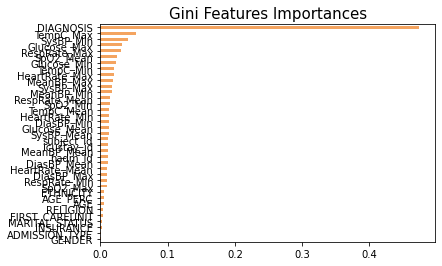

In [46]:
plot_feats(rf2)

In [52]:
rf_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_tr),
                                                 mode="regression",
                                                 feature_names=X_tr.columns)

In [53]:
rf_exp = rf_explainer.explain_instance(data_row = X_tr.iloc[5],
                                       predict_fn = rf2.predict)

rf_exp.show_in_notebook(show_table = True)

In [55]:
def rf_display_explanation(row_index):
    rf_exp = rf_explainer.explain_instance(data_row=X_tr.iloc[row_index], 
                                           predict_fn=rf2.predict)
    rf_exp.show_in_notebook(show_table=True)

input_field = widgets.IntText(value=5, description='Row index:')
button = widgets.Button(description='Explain')


def rf_on_button_click(button):
    rf_display_explanation(input_field.value)

In [56]:
button.on_click(rf_on_button_click)

display(widgets.VBox([input_field, button]))

store predictions for Kaggle

In [57]:
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": predictions_rf2})
test_predictions_submit.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit.csv", index = False)

#### XGBoost

In [63]:
xgb2 = tuning(xgb, parameters_xgb, X_tr, y_tr)
xgb2

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)  



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [64]:
xgb2, predictions_xgb2 = fit_n_predict(X_tr, X_te, y_tr, xgb2)

Model Explenation - XGBoost

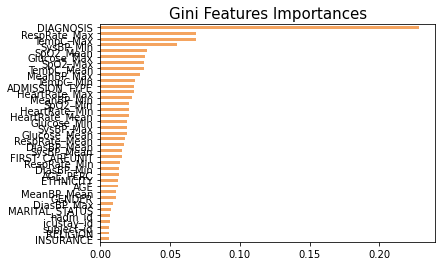

In [65]:
plot_feats(xgb2)

In [66]:
xgb_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_tr),
                                                  mode="regression",
                                                  feature_names=X_tr.columns)

In [67]:
def xgb_display_explanation(row_index):
    xgb_exp = xgb_explainer.explain_instance(data_row=X_tr.iloc[row_index], 
                                             predict_fn=xgb2.predict)
    xgb_exp.show_in_notebook(show_table=True)

input_field = widgets.IntText(value=5, description='Row index:')
button = widgets.Button(description='Explain')


def xgb_on_button_click(button):
    xgb_display_explanation(input_field.value)

In [68]:
button.on_click(xgb_on_button_click)

display(widgets.VBox([input_field, button]))

store predictions for Kaggle

In [69]:
test_predictions_submit2 = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": predictions_xgb2})
test_predictions_submit2.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit2.csv", index = False)

### Build Ensemble
To build my ensebemle model I want to experiment with as many models as possible to mitigate that some models are more sensible to certain data. I will use the *SuperLearner()* which stacks models and assigns weights to the predictions. To ensemble the *SuperLearner()* I first have to initiate some models.

#### Ridge
I'll start with a simple ridge regression

In [70]:
ridge=Ridge()

In [71]:
ridge_parameters = {'alpha' : [0.001, 0.01, 0.1, 1, 5, 10, 15]}

In [72]:
ridge2 = tuning(ridge, ridge_parameters, X_tr, y_tr)

ridge2

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Estimator:  Ridge(alpha=0.1)  



Ridge(alpha=0.1)

In [73]:
ridge2, predictions_ridge2 = fit_n_predict(X_tr, X_te, y_tr, ridge2)

In [74]:
test_predictions_submit3 = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": predictions_ridge2})
test_predictions_submit3.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit3.csv", index = False)

#### Quantile Regression 
Since the data is noisy, a median regressions may do better

In [77]:
qr = lgmr(objective='quantile', alpha=0.5)

In [78]:
qr, predictions_qr = fit_n_predict(X_tr, X_te, y_tr, qr)

In [79]:
test_predictions_submit4 = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": predictions_qr})
test_predictions_submit4.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit4.csv", index = False)

Now I instanticate, stack, and fit the *SuperLearner()* and susequently make predictions

In [80]:
super_learner = SuperLearner()

In [81]:
regression_learners = [
    lgmr(objective='quantile', alpha=0.5),
    Ridge(alpha=0.1)
]

tree_learners = [
    RandomForestRegressor(max_depth=22, max_features='sqrt', min_samples_split=48,
                      n_estimators=125, random_state=1),
                 
    XGBRegressor(colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, 
                 max_depth=8, n_estimators=100, random_state=1)
]

In [82]:
super_learner = SuperLearner(folds=5, verbose=2, scorer=mse)
super_learner.add(regression_learners)
super_learner.add(tree_learners)

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...r=False))],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=make_scorer(mean_squared_error, greater_is_better=False),
       shuffle=False, verbose=2)

In [90]:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(super_learner, X_tr, y_tr, cv=5, scoring=mse)
# scores = np.mean(scores, axis=1).tolist()

# print("Cross-Validation RMSE: {:.3f} (+/- {:.3f})".format(scores.mean(), scores.std()))

In [91]:
super_learner.fit(X_tr, y_tr)

predictions_sl = super_learner.predict(X_te)
predictions_sl


Fitting 2 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:14
Fit complete                        | 00:00:22

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:02


array([[0.4774696 , 0.59991264],
       [1.0345817 , 1.0288048 ],
       [1.0516492 , 1.0378813 ],
       ...,
       [0.65837204, 0.66638404],
       [1.3923302 , 1.2195266 ],
       [1.1860963 , 1.3221654 ]], dtype=float32)

In [92]:
aggr_preds_sl = np.mean(predictions_sl, axis=1).tolist()
aggr_preds_sl[0:3]

[0.5386911034584045, 1.0316932201385498, 1.0447652339935303]

In [93]:
test_predictions_submit_sl = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": aggr_preds_sl})
test_predictions_submit_sl.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit_sl.csv", index = False)

### Neural Network

In [94]:
nn = Sequential()
nn.add(Dropout(0.2, input_shape=(37,)))
nn.add(Dense(32, activation='relu', kernel_constraint=MaxNorm(3)))
nn.add(Dense(16, activation='relu', kernel_constraint=MaxNorm(3)))
nn.add(Dense(1, activation='linear'))

In [97]:
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [98]:
history = nn.fit(sc_X_tr, y_tr, epochs=250, batch_size=2, validation_split=0.33, verbose=0)

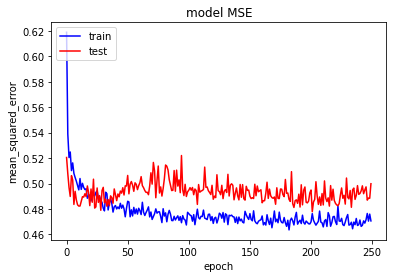

In [102]:
plt.plot(history.history['mean_squared_error'], color='b')
plt.plot(history.history['val_mean_squared_error'], color='r')
plt.title('model MSE')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
nn.save('/content/gdrive/MyDrive/DeepLearning/my_model1.1')

In [104]:
nn_pred = nn.predict(sc_X_te)
nn_pred

164/164 [==============================] - 0s 1ms/step


array([[0.91283375],
       [0.6655228 ],
       [0.9722047 ],
       ...,
       [0.7805474 ],
       [1.1626401 ],
       [0.901938  ]], dtype=float32)

In [105]:
type(nn_pred)

numpy.ndarray

In [106]:
nn_pred = nn_pred.tolist()
nn_pred[0:3]

[[0.9128337502479553], [0.6655228137969971], [0.9722046852111816]]

In [108]:
# convert tensor to list
flat_list = []
for sublist in nn_pred:
    for item in sublist:
        flat_list.append(item)


flat_list[0:3]

[0.9128337502479553, 0.6655228137969971, 0.9722046852111816]

In [109]:
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": flat_list})
test_predictions_submit.to_csv("/content/gdrive/MyDrive/DeepLearning/test_predictions_submit_nn.csv", index = False)